https://www.datacamp.com/tutorial/random-forests-classifier-python
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [1]:
import pandas as pd
from itertools import product
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
original = pd.read_csv('train.csv')


In [3]:
# drop rows where tempo is missing
original = original[original['Tempo'].notna()]
# drop rows where genre speechness and valence are missing
original = original[original['Speechiness'].notna()]
# original = original[original['Valence'].notna()]

In [4]:
training_Y = original['Danceability']
original.drop(['Danceability'], axis=1, inplace=True) 

In [5]:
def fillOptions(data, option = 'max'):
    if data.isna().sum() != len(data):
        if option == 'max':
            return data.value_counts().idxmax()
        elif option == 'mean':
            return data.mean()
        elif option == 'median':
            return data.median()

In [6]:
def verifyID(original, newData):
    noInNewData = original[~original['id'].isin(newData['id'])]
    return pd.concat([newData, noInNewData], ignore_index=True)   

In [7]:
def filterArtistComposerDance(data, nameColumnFill):

    listArtist = data['Artist'].unique()
    listComposer = data['Composer'].unique()
    
    filter = list(product(listArtist, listComposer))

    newData = pd.DataFrame(columns=data.columns)

    for i in filter:
        artist, composer = i[0], i[1]
        filterData = data[(data['Artist'] == artist) & (data['Composer'] == composer) ]
        if len(filterData) != 0:
            # Fill column Name
            for nameColumn in nameColumnFill:
                fillInfo = fillOptions(filterData[nameColumn], option = 'max')
                if fillInfo != None:
                    filterData.loc[:,nameColumn].fillna(fillInfo, inplace=True)

            newData = pd.concat([newData, filterData], ignore_index=True)
    return newData

In [8]:
def filterArtist(data, nameColumnFill):
    listDance = data['Artist'].unique()
    filter = listDance


    newData = pd.DataFrame(columns=data.columns)

    for i in filter:
        dance = i
        filterData = data[ (data['Artist'] == dance)]
    
    
        if len(filterData) != 0:
            # Fill column Name
            for nameColumn in nameColumnFill:
                fillInfo = fillOptions(filterData[nameColumn], option = 'max')
                if fillInfo != None:
                    filterData.loc[:,nameColumn].fillna(fillInfo, inplace=True)

            newData = pd.concat([newData, filterData], ignore_index=True)

    return newData

In [9]:
def filterFillData(data, nameColumnFill):
    if not data.isnull().any().any():
        return data
    else:
        for nameColumn in nameColumnFill:
            fillInfo = fillOptions(data[nameColumn], option = 'max')
            if fillInfo != None:
                data.loc[:,nameColumn].fillna(fillInfo, inplace=True)
    return data



In [10]:
def dataPreprocessing(original):
    
    pd.options.mode.chained_assignment = None

    data = original.copy()

    nameColumnFill = ['Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Duration_ms', 'Views', 'Likes', "Stream" , "Comments"]

    # License and official_video
    data['Licensed'].fillna(data['official_video'], inplace=True)
    data['Licensed'].fillna(False, inplace=True)

    data['official_video'].fillna(data['Licensed'], inplace=True)
    data['official_video'].fillna(False, inplace=True)

    data['official_video'].fillna(False, inplace=True)
    data['Licensed'].fillna(False, inplace=True)

    data['Licensed'].replace({True: 1, False: 0})
    data['official_video'].replace({True: 1, False: 0})

    # Create new class = 'Unknown'
    data['Composer'].fillna("Unknown", inplace=True)
    data['Artist'].fillna("Unknown", inplace=True)
    data['Album_type'].fillna("Unknown", inplace=True)

    

    newData = filterArtistComposerDance(data, nameColumnFill)
    data = newData.copy()

    newData = filterArtist(data, nameColumnFill)
    data = newData.copy()

    newData = filterFillData(data, nameColumnFill)
    data = newData.copy()

    #Transform type key to use as class
    data['Key'] = data['Key'].astype(int)
    data['Key'] = data['Key'].astype(str)

    data = data.sort_values('id')

    # DELETE Track, Album, Uri, Url_spotify, Url_youtube, Description, Title, Channel, id, Comments
    data.drop(['Track', 'Album', 'Uri', 'Url_spotify', 'Url_youtube', 'Description', 'Title', 'Channel', 'id'], axis=1, inplace=True)

    pd.options.mode.chained_assignment = 'warn'

    return data
    


In [11]:
def convertEncoderPD(data, prefix = 'key'):
    titleKeys = []
    for i in range(data.shape[1]):
        titleKeys.append(f'{prefix}_{i}')
    
    return pd.DataFrame(data=data, columns= titleKeys)


In [12]:
def createEncodeDataTraining(data):

    encoderKey = OneHotEncoder()
    encodedKey = encoderKey.fit_transform(data[['Key']])
    Key = encodedKey.toarray()
    key_pd = convertEncoderPD(Key, prefix = 'key')

    encoderAlbumType = OneHotEncoder()
    encodedKeyAlbumType = encoderAlbumType.fit_transform(data[['Album_type']])
    AlbumType = encodedKeyAlbumType.toarray()
    AlbumType_pd = convertEncoderPD(AlbumType, prefix = 'AlbumType')

    encoderComposer = OneHotEncoder()
    encodedKeyComposer = encoderComposer.fit_transform(data[['Composer']])
    Composer = encodedKeyComposer.toarray()
    Composer_pd = convertEncoderPD(Composer, prefix = 'Composer')   

    encoderArtist = LabelEncoder()
    encodedArtist = encoderArtist.fit_transform(data[['Artist']])
    encodedArtist = encodedArtist.ravel()
    Artist_pd =  pd.DataFrame(data=encodedArtist, columns= ["Artist"])

    data.drop(['Key','Album_type', 'Composer',  'Artist'], axis=1, inplace=True)

    data = pd.concat([data, key_pd, AlbumType_pd, Composer_pd, Artist_pd], axis=1)

    scaler = StandardScaler()
    scaledData = scaler.fit_transform(data)

    scaledData_pd = pd.DataFrame(data=scaledData, columns= data.columns)

    return {"key": encoderKey, 'AlbumType': encoderAlbumType, 'Composer': encoderComposer, "Artist":encoderArtist} , scaler, data, scaledData_pd
    

In [13]:
def createEncodeDataTesting(encoder, scalerStandard, data):

    encoderKey = encoder['key']
    encodedKey = encoderKey.transform(data[['Key']])
    Key = encodedKey.toarray()
    key_pd = convertEncoderPD(Key, prefix = 'key')

    encoderAlbumType = encoder['AlbumType']
    encodedKeyAlbumType = encoderAlbumType.transform(data[['Album_type']])
    AlbumType = encodedKeyAlbumType.toarray()
    AlbumType_pd = convertEncoderPD(AlbumType, prefix = 'AlbumType')

    encoderComposer = encoder['Composer']
    encodedKeyComposer = encoderComposer.transform(data[['Composer']])
    Composer = encodedKeyComposer.toarray()
    Composer_pd = convertEncoderPD(Composer, prefix = 'Composer')   

    encoderArtist = encoder['Artist']
    encodedArtist = encoderArtist.transform(data[['Artist']])
    encodedArtist = encodedArtist.ravel()
    Artist_pd =  pd.DataFrame(data=encodedArtist, columns= ["Artist"])

    data.drop(['Key','Album_type', 'Composer',  'Artist'], axis=1, inplace=True)

    data = pd.concat([data, key_pd, AlbumType_pd, Composer_pd, Artist_pd], axis=1)

    scaler = scalerStandard
    scaledData = scaler.transform(data)

    scaledData_pd = pd.DataFrame(data=scaledData, columns= data.columns)

    return data, scaledData_pd

In [14]:
data = dataPreprocessing(original)

/tmp/ipykernel_19864/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_19864/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_19864/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_19864/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Exp

In [15]:
encoders, scalerStandard, data, scaledData_pd = createEncodeDataTraining(data)

/home/zow/anaconda3/envs/fintech2/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
test = pd.read_csv('test.csv')
dataTest = dataPreprocessing(test)
testOriginal, testScaled = createEncodeDataTesting(encoders, scalerStandard, dataTest)

/tmp/ipykernel_19864/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_19864/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_19864/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_19864/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Exp

In [17]:
scaledData_pd

,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Stream,Licensed,official_video,Comments,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,AlbumType_0,AlbumType_1,AlbumType_2,AlbumType_3,Composer_0,Composer_1,Composer_2,Composer_3,Composer_4,Composer_5,Composer_6,Composer_7,Composer_8,Composer_9,Composer_10,Artist
0,-1.399795,-3.827233,-0.497006,2.704102,-0.265440,-0.283654,-0.783207,-1.264744,-0.930713,-0.217371,-0.276058,-0.450335,-1.525889,-1.777601,-0.100591,-0.355708,-0.332767,-0.470964,-0.318418,5.894182,-0.271006,-0.283285,-0.264279,-0.362840,-0.276942,-0.316116,-0.416940,0.807337,-0.175343,-0.525936,-0.460868,-0.068447,-0.346753,-0.374658,-0.276605,-0.267572,-0.239173,-0.087264,-0.417073,2.39309,-0.320863,0.091453
1,-0.528389,0.323442,-0.659065,-0.513039,-0.265787,-0.281959,-0.848698,0.984142,0.354949,0.488986,0.244138,1.214169,0.655356,0.562556,-0.004466,-0.355708,-0.332767,-0.470964,-0.318418,-0.169659,-0.271006,-0.283285,-0.264279,2.756033,-0.276942,-0.316116,-0.416940,0.807337,-0.175343,-0.525936,-0.460868,-0.068447,-0.346753,-0.374658,-0.276605,-0.267572,-0.239173,-0.087264,-0.417073,2.39309,-0.320863,0.549736
2,0.076568,0.611851,-0.675661,-0.529980,-0.263172,-0.265066,-0.967399,-0.773416,0.345046,0.959105,0.426967,-0.471334,0.655356,0.562556,0.026250,-0.355708,-0.332767,-0.470964,3.140523,-0.169659,-0.271006,-0.283285,-0.264279,-0.362840,-0.276942,-0.316116,-0.416940,0.807337,-0.175343,-0.525936,-0.460868,-0.068447,-0.346753,2.669101,-0.276605,-0.267572,-0.239173,-0.087264,-0.417073,-0.41787,-0.320863,-1.152459
3,0.441081,0.794108,-0.611228,-0.529915,-0.265787,-0.282450,1.271564,-0.603964,0.316142,-0.343205,-0.358801,0.345249,-1.525889,-1.777601,-0.113826,-0.355708,-0.332767,2.123303,-0.318418,-0.169659,-0.271006,-0.283285,-0.264279,-0.362840,-0.276942,-0.316116,-0.416940,-1.238640,5.703123,-0.525936,-0.460868,-0.068447,-0.346753,-0.374658,-0.276605,-0.267572,4.181080,-0.087264,-0.417073,-0.41787,-0.320863,1.237161
4,-0.460604,0.709450,-0.614157,0.771567,-0.265724,-0.195978,-1.417648,1.537697,0.294002,-0.028330,-0.206596,0.059743,0.655356,0.562556,-0.083471,-0.355708,-0.332767,2.123303,-0.318418,-0.169659,-0.271006,-0.283285,-0.264279,-0.362840,-0.276942,-0.316116,2.398425,-1.238640,-0.175343,-0.525936,-0.460868,-0.068447,-0.346753,-0.374658,-0.276605,-0.267572,-0.239173,-0.087264,-0.417073,2.39309,-0.320863,1.138958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12433,1.378539,0.554169,-0.460884,-0.472034,-0.265787,-0.008425,0.375160,-0.633076,-1.139671,-0.344164,-0.359198,-0.494435,0.655356,0.562556,-0.114458,2.811292,-0.332767,-0.470964,-0.318418,-0.169659,-0.271006,-0.283285,-0.264279,-0.362840,-0.276942,-0.316116,-0.416940,0.807337,-0.175343,-0.525936,-0.460868,-0.068447,-0.346753,-0.374658,-0.276605,-0.267572,-0.239173,-0.087264,2.397661,-0.41787,-0.320863,0.844347
12434,1.904748,0.303045,-0.609276,-0.128427,-0.265787,-0.285553,0.518421,-1.042487,-1.133841,-0.338653,-0.358686,0.013016,0.655356,0.562556,-0.114458,-0.355708,-0.332767,-0.470964,-0.318418,-0.169659,-0.271006,-0.283285,-0.264279,-0.362840,-0.276942,3.163397,2.398425,-1.238640,-0.175343,-0.525936,-0.460868,-0.068447,-0.346753,-0.374658,-0.276605,-0.267572,-0.239173,-0.087264,2.397661,-0.41787,-0.320863,0.549736
12435,0.979535,0.668217,-0.297849,-0.273140,-0.265787,-0.258675,-0.459847,1.595584,-0.765212,-0.344083,-0.359160,-0.220541,0.655356,0.562556,-0.114458,-0.355708,-0.332767,2.123303,-0.318418,-0.169659,-0.271006,-0.283285,-0.264279,-0.362840,-0.276942,-0.316116,2.398425,-1.238640,-0.175343,-0.525936,-0.460868,-0.068447,-0.346753,-0.374658,3.615264,-0.267572,-0.239173,-0.087264,-0.417073,-0.41787,-0.320863,-1.741681
12436,0.477580,-0.891823,3.161033,-0.328494,-0.265787,-0.279679,0.031334,1.157734,-1.013922,-0.344203,-0.321112,-0.507797,0.655356,0.

In [18]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(scaledData_pd, training_Y, test_size = 0.20, random_state = 123)

### RandomForestRegressor

In [19]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
import pickle

#Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

# filename = "random_forest_regressor.joblib"
# pickle.dump(rf, open(filename, "wb"))

RandomForestRegressor(n_estimators=1000, random_state=42)

In [20]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
predictions = np.rint(predictions)
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 1.67


In [21]:
# Use the forest's predict method on the test data
predictionsTest = rf.predict(testScaled)
predictionsTest = np.rint(predictionsTest)


In [22]:
predictionTest_pd = pd.DataFrame(data = predictionsTest, columns= ['Danceability'])
predictionTest_pd.to_csv('RandomForestRegressor.csv')

In [23]:
preds = np.rint(predictionsTest)
preds = preds.astype(int)
preds = pd.DataFrame(preds, columns=['Danceability'])
preds['id'] = preds.index + 17170
preds = preds[['id', 'Danceability']]
preds.to_csv('submissionRF.csv', index=False)

In [24]:
# # load model
# loaded_model = pickle.load(open(filename, "rb"))
# # you can use loaded model to compute predictions
# predicted = loaded_model.predict(test_features)

# predicted = np.rint(predicted)
# errors = abs(predicted - test_labels)
# # Print out the mean absolute error (mae)
# print('Mean Absolute Error:', round(np.mean(errors), 2))

# XGBOOST

In [25]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
best_params = {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.4, 'n_estimators': 400, 'min_child_weight': 4, 'max_depth': 30, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.8, 'random_state': 0}
default_params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'random_state': 0,
    'n_jobs': -1
}

best_model = XGBRegressor(**default_params)
best_model.fit(train_features, train_labels)


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [26]:

preds = best_model.predict(test_features)
mae = mean_absolute_error(test_labels, preds)
print(f"MAE without CV: {mae}")

MAE without CV: 1.715749448766839


In [27]:
best_model.feature_importances_

array([7.39511102e-02, 5.66451289e-02, 1.54760346e-01, 1.06848165e-01,
       3.60449702e-02, 3.04354448e-02, 1.96319774e-01, 1.35938868e-01,
       2.63723731e-02, 2.06439923e-02, 3.35511193e-02, 1.23342918e-02,
       4.93185034e-05, 1.68998372e-02, 1.24495896e-02, 1.31373731e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.15709417e-02,
       5.42993471e-03, 0.00000000e+00, 1.13744857e-02, 0.00000000e+00,
       9.46702342e-03, 9.05016717e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.35410988e-03,
       9.06461477e-03, 8.30698013e-03], dtype=float32)

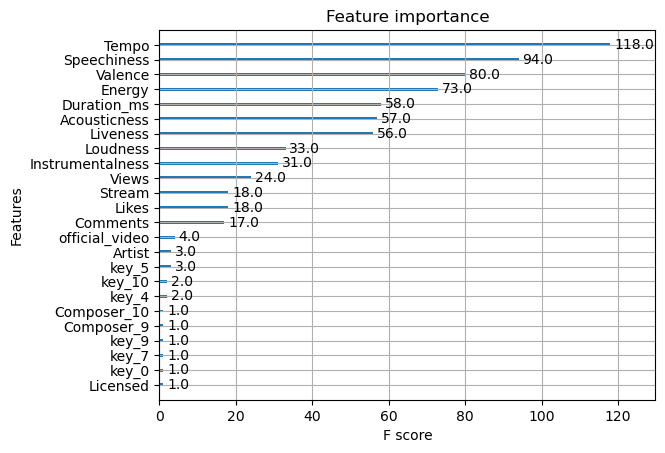

In [28]:
# plot feature importance
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(best_model)
pyplot.show()

In [29]:
# Use the forest's predict method on the test data
predictionsTest = best_model.predict(testScaled)
predictionsTest = np.rint(predictionsTest)
predictionTest_pd = pd.DataFrame(data = predictionsTest, columns= ['Danceability'])
predictionTest_pd.to_csv('XGB.csv')


In [30]:
preds = np.rint(predictionsTest)
preds = preds.astype(int)
preds = pd.DataFrame(preds, columns=['Danceability'])
preds['id'] = preds.index + 17170
preds = preds[['id', 'Danceability']]
preds.to_csv('submission.csv', index=False)

# ADABOOST

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
base_estimator = DecisionTreeRegressor(max_depth=3, splitter='best', min_samples_split=2)
model = AdaBoostRegressor(base_estimator=base_estimator,n_estimators=500, random_state=42) #n_estimators = 1000, random_state = 42
model.fit(train_features, train_labels)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  n_estimators=500, random_state=42)

In [32]:

preds = model.predict(test_features)
mae = mean_absolute_error(test_labels, preds)
print(f"MAE without CV: {mae}")

MAE without CV: 2.017358980316145


# LIGHTGBM

In [33]:
import lightgbm as lgb
lgb_train = lgb.Dataset(train_features, train_labels)
lgb_eval = lgb.Dataset(test_features, test_labels, reference=lgb_train)
params = {'boosting_type': 'gbdt',
              'objective': 'regression',
              'num_leaves': 40,
              'learning_rate': 0.1,
              'feature_fraction': 0.9
              }
gbm = lgb.train(params,
    lgb_train,
    num_boost_round=200,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=['train','valid'],
   )


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3496
[LightGBM] [Info] Number of data points in the train set: 9950, number of used features: 42
[LightGBM] [Info] Start training from score 4.608141
[1]	train's l2: 7.6968	valid's l2: 7.57403
[2]	train's l2: 7.14434	valid's l2: 7.08455
[3]	train's l2: 6.68259	valid's l2: 6.67644
[4]	train's l2: 6.30061	valid's l2: 6.33466
[5]	train's l2: 6.03832	valid's l2: 6.11367
[6]	train's l2: 5.74476	valid's l2: 5.85785
[7]	train's l2: 5.49683	valid's l2: 5.65494
[8]	train's l2: 5.27841	valid's l2: 5.46373
[9]	train's l2: 5.09237	valid's l2: 5.31322
[10]	train's l2: 4.93053	valid's l2: 5.18591
[11]	train's l2: 4.78815	valid's l2: 5.08086
[12]	train's l2: 4.6673	valid's l2: 4.99023
[13]	train's l2: 4.54553	valid's l2: 4.90081
[14]	train's l2: 4.44954	valid's l2: 4.82573
[15]	train's l2: 4.35836	valid's l2: 

In [34]:

preds = gbm.predict(test_features)
mae = mean_absolute_error(test_labels, preds)
print(f"MAE without CV: {mae}")

MAE without CV: 1.6353534798063918


In [35]:
# Use the forest's predict method on the test data
predictionsTest = gbm.predict(testScaled)
preds = np.rint(predictionsTest)
preds = preds.astype(int)
preds = pd.DataFrame(preds, columns=['Danceability'])
preds['id'] = preds.index + 17170
preds = preds[['id', 'Danceability']]
preds.to_csv('submission.csv', index=False)

# Ensemble

In [39]:
class LGBWrapper:
    def __init__(self, params, num_boost_round, valid_sets, valid_names):
        self.params = params
        self.num_boost_round = num_boost_round
        self.valid_sets = valid_sets
        self.valid_names = valid_names
        self.model = None

    def fit(self, X, y):
        lgb_train = lgb.Dataset(X, y, free_raw_data=False)
        self.valid_sets[0] = lgb_train
        self.model = lgb.train(self.params, lgb_train, num_boost_round=self.num_boost_round,
                               valid_sets=self.valid_sets, valid_names=self.valid_names)

    def predict(self, X):
        return self.model.predict(X)


In [43]:
from sklearn.ensemble import VotingClassifier, VotingRegressor

# Instantiate the classfiers and make a list
regressors = [
    RandomForestRegressor(n_estimators=1000, random_state=42),
    RandomForestRegressor(n_estimators=2000, random_state=42),
    XGBRegressor(**default_params),
    AdaBoostRegressor(base_estimator=base_estimator, n_estimators=500, random_state=42),
    # LGBWrapper(params, num_boost_round=200, valid_sets=[lgb_train, lgb_eval], valid_names=['train', 'valid'])
]
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['regressors', 'mae'])

# Train and evaluate each classifier
for reg in regressors:
    reg.fit(train_features, train_labels)
    pred = reg.predict(test_features)
    mae = mean_absolute_error(test_labels, pred)
    result_table = result_table.append({'regressors':reg.__class__.__name__, 'mae': mae}, ignore_index=True)

result_table.set_index('mae', inplace=True)
result_table.sort_values(by=['mae'], ascending=True)

# A voting regressor is an ensemble meta-estimator that fits several base regressors, each on the whole dataset. 
# Then it averages the individual predictions to form a final prediction.
predictionsTest = reg.predict(testScaled)
preds = np.rint(predictionsTest)


/tmp/ipykernel_19864/4138367875.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'regressors':reg.__class__.__name__, 'mae': mae}, ignore_index=True)


In [ ]:
result_table

,regressors
mae,
1.681766,RandomForestRegressor
1.715749,XGBRegressor
2.017359,AdaBoostRegressor
